In [1]:
# Import packages to use
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams.update({'errorbar.capsize': 2})

//anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [8]:
#Define the file to explore
file05='resumen_N100_Niter3000000_beta0.5_dt1e-08_lf0.5_stf50_Nsimstot1368_mul10.csv'
file1='resumen_N100_Niter2000000_beta0.5_dt1e-05_lf1.0_stf0_Nsimstot1000_mul10.csv'
file2='resumen_N100_Niter2000000_beta0.5_dt1e-05_lf2.0_stf0_Nsimstot2000_mul10.csv'
file4='resumen_N100_Niter2000000_beta0.5_dt1e-05_lf4.0_stf0_Nsimstot2000_mul10.csv'
file8='resumen_N100_Niter2000000_beta0.5_dt1e-05_lf8.0_stf0_Nsimstot2000_mul10.csv'

# Define the parameters for the simulation
N=100
beta=0.5
nu=-1/(beta+1)

dt05=1e-8
dt1=5e-8
dt2=1e-5
dt4=1e-5
dt8=1e-5

# Import the data file
df05=pd.read_csv(file05, engine='python')
df1=pd.read_csv(file1, engine='python')
df2=pd.read_csv(file2, engine='python')
df4=pd.read_csv(file4, engine='python')
df8=pd.read_csv(file8, engine='python')

print(df2.columns.tolist())
print('Theoretical exponent (nu)= %g'%nu)

['t', 'log_t', 'N_avg', 'std_N', 'log_N']
Theoretical exponent (nu)= -0.666667


In [9]:
# We account for the fact that there are 50 initial simulations without fusion
# Therefore we substract 50*dt from the time and create a new data frame
# We take the data from the 6-th index onwards to erase negative times
df05_50=df05.copy()
df05_50['t']=df05_50['t']-50*dt05
df05_50=df05_50[6:]
# Recalculate log(t)
df05_50['log_t']=np.log(df05_50['t'])

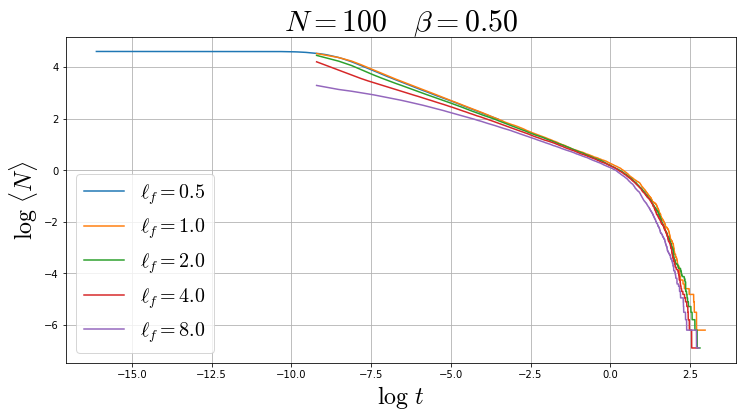

In [10]:
# Plot the entire log-data
# Plot the data 
plt.figure(figsize=(12,6))

plt.plot(df05_50.log_t,df05_50.log_N, label=r'$\ell_f=0.5$')
plt.plot(df1.log_t,df1.log_N, label=r'$\ell_f=1.0$')
plt.plot(df2.log_t,df2.log_N, label=r'$\ell_f=2.0$')
plt.plot(df4.log_t,df4.log_N, label=r'$\ell_f=4.0$')
plt.plot(df8.log_t,df8.log_N, label=r'$\ell_f=8.0$')

plt.xlabel(r'$\log \ t$',fontsize=24)
plt.ylabel(r'$\log \ \langle N \rangle $',fontsize=24)

plt.title(r'$N=%i \quad \beta=%.2f$'%(N,beta),fontsize=30)
plt.grid(zorder=3)
plt.legend(fontsize=20)
plt.show()
plt.close()

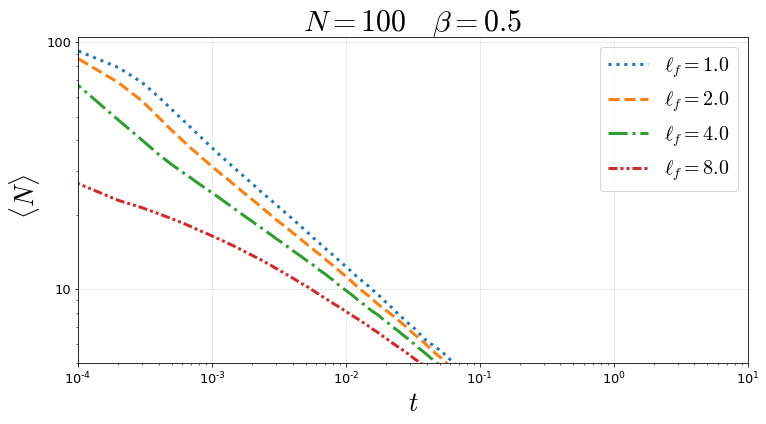

In [11]:
# Plot the entire log-data
# Plot the data 
fig,ax=plt.subplots(figsize=(12,6))

#ax.plot(df05_50.t,df05_50.N_avg, label=r'$\ell_f=0.5$',linestyle='solid')
ax.plot(df1.t,df1.N_avg, label=r'$\ell_f=1.0$',linestyle='dotted',linewidth=3)
ax.plot(df2.t,df2.N_avg, label=r'$\ell_f=2.0$',linestyle='dashed',linewidth=3)
ax.plot(df4.t,df4.N_avg, label=r'$\ell_f=4.0$',linestyle='dashdot',linewidth=3)
ax.plot(df8.t,df8.N_avg, label=r'$\ell_f=8.0$',linestyle=(0, (3, 1, 1, 1, 1, 1)),linewidth=3)

ax.set_xlim(left=1e-4,right=10)
ax.set_ylim(bottom=5)
ax.set_xlabel(r'$t$',fontsize=26)
ax.set_ylabel(r'$\ \langle N \rangle $',fontsize=26)
ax.set_yscale('log')
ax.set_xscale('log')
ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
#ax.yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
ax.ticklabel_format(style='plain',axis='y',useOffset=False)
ax.tick_params(axis='both', labelsize=13)

ax.set_title(r'$N=%i \quad \beta=%.1f$'%(N,beta),fontsize=30)
ax.grid(zorder=3,alpha=0.3)
ax.legend(fontsize=20)
plt.show()
plt.close()

In [12]:
# Cut the data in order to analyze the last part
# The cut-value can be changed and will change the results
cut=-5
cut2=-1.5
df_tail05=df05_50[(df05_50['log_t']>cut) & (df05_50['log_t']<cut2)]

cut=-5
cut2=-1
df_tail1=df1[(df1['log_t']>cut) & (df1['log_t']<cut2)]

cut=-5
cut2=-1
df_tail2=df2[(df2['log_t']>cut) & (df2['log_t']<cut2)]

cut=-5
cut2=-1
df_tail4=df4[(df4['log_t']>cut) & (df4['log_t']<cut2)]

cut=-4
cut2=-0.5
df_tail8=df8[(df8['log_t']>cut) & (df8['log_t']<cut2)]

In [13]:
# Perform fit of the form y=ax+b
# Define function to calculate a,b,err_a,err_b
def regression(x,y,err_y):
    n=len(x)
    xiyi=np.sum(np.multiply(x,y))
    xi=np.sum(x)
    yj=np.sum(y)
    xi2=np.sum(np.square(x))
    xidyi=np.sum(np.multiply(x,err_y))
    dyj=np.sum(err_y)
    den=n*xi2-xi**2
    
    a=(n*xiyi-xi*yj)/den
    b=(xi2*yj-xi*xiyi)/den
    err_a=(n*xidyi-xi*dyj)/den
    err_b=(xi2*dyj-xi*xidyi)/den
    
    return a,b,err_a,err_b

In [14]:
xreg=df_tail05['log_t']
yreg=df_tail05['log_N']
y_err=np.divide(df_tail05['std_N'],df_tail05['N_avg'])

nu_res05,intercept05,err_nu05,err_int05=regression(xreg,yreg,y_err)
print('Regression for lf=0.5')
print('nu-exponent: %f'%nu_res05)
print('nu-error: %f'%err_nu05)
print('constant: %f'%intercept05)
print('constant error: %f'%err_int05)

#--------------------------------------------------------------

xreg=df_tail1['log_t']
yreg=df_tail1['log_N']
y_err=np.divide(df_tail1['std_N'],df_tail1['N_avg'])

nu_res1,intercept1,err_nu1,err_int1=regression(xreg,yreg,y_err)
print('Regression for lf=1.0')
print('nu-exponent: %f'%nu_res1)
print('nu-error: %f'%err_nu1)
print('constant: %f'%intercept1)
print('constant error: %f'%err_int1)

#--------------------------------------------------------------

xreg=df_tail2['log_t']
yreg=df_tail2['log_N']
y_err=np.divide(df_tail2['std_N'],df_tail2['N_avg'])

nu_res2,intercept2,err_nu2,err_int2=regression(xreg,yreg,y_err)
print('Regression for lf=2.0')
print('nu-exponent: %f'%nu_res2)
print('nu-error: %f'%err_nu2)
print('constant: %f'%intercept2)
print('constant error: %f'%err_int2)

#--------------------------------------------------------------

xreg=df_tail4['log_t']
yreg=df_tail4['log_N']
y_err=np.divide(df_tail4['std_N'],df_tail4['N_avg'])

nu_res4,intercept4,err_nu4,err_int4=regression(xreg,yreg,y_err)
print('Regression for lf=4.0')
print('nu-exponent: %f'%nu_res4)
print('nu-error: %f'%err_nu4)
print('constant: %f'%intercept4)
print('constant error: %f'%err_int4)

#--------------------------------------------------------------

xreg=df_tail8['log_t']
yreg=df_tail8['log_N']
y_err=np.divide(df_tail8['std_N'],df_tail8['N_avg'])

nu_res8,intercept8,err_nu8,err_int8=regression(xreg,yreg,y_err)
print('Regression for lf=8.0')
print('nu-exponent: %f'%nu_res8)
print('nu-error: %f'%err_nu8)
print('constant: %f'%intercept8)
print('constant error: %f'%err_int8)


Regression for lf=0.5
nu-exponent: -0.479678
nu-error: 0.060899
constant: 0.285949
constant error: 0.491831
Regression for lf=1.0
nu-exponent: -0.494562
nu-error: 0.097356
constant: 0.244293
constant error: 0.612509
Regression for lf=2.0
nu-exponent: -0.470896
nu-error: 0.090177
constant: 0.261064
constant error: 0.599848
Regression for lf=4.0
nu-exponent: -0.450595
nu-error: 0.093023
constant: 0.238041
constant error: 0.625214
Regression for lf=8.0
nu-exponent: -0.440915
nu-error: 0.120154
constant: 0.161513
constant error: 0.700770
